In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir('/Users/kelvin/Desktop/citadel datathon/')

acs =            pd.read_csv('data/acs_5yr_est_selected_economic_characteristics_2010-2022.csv')
commodities =    pd.read_csv('data/all_commodities.csv')
s_and_e =        pd.read_csv('data/all_stocks_and_etfs.csv')
e_consumption =  pd.read_csv('data/Energy Data - Consumption.csv')
e_emissions =    pd.read_csv('data/Energy Data - Emissions.csv')
e_goods =        pd.read_csv('data/Energy Data - Imports & Exports.csv')
e_prod =         pd.read_csv('data/Energy Data - Production.csv')
e_stocks =       pd.read_csv('data/Energy Data - Stocks.csv')
transportation = pd.read_csv('data/monthly_transportation_statistics.csv')
stock_desc =     pd.read_csv('data/stock_descriptions.csv')

In [40]:
# ONEQ split adjustment
s_and_e['Date-Time'] = pd.to_datetime(s_and_e['Date-Time'])
split_day = pd.to_datetime('2021-04-08')
s_and_e.loc[(s_and_e['Date-Time'] >= split_day) &
            (s_and_e['Ticker_Symbol'] == 'ONEQ'),
            ['Open', 'High', 'Low', 'Close']] *= 10

In [41]:
pivoted_s_e = s_and_e.pivot(index='Date-Time', columns='Ticker_Symbol', values='Close')
pd.set_option('display.max_rows', None)

In [42]:
display(pivoted_s_e.head(5))

Ticker_Symbol  BKR     BP    BPT  CEO  CHK    COP    CVX    DIA    DVN      E  \
Date-Time                                                                       
1999-11-01     NaN  57.25  8.750  NaN  NaN  46.63  91.44  106.5  38.88  58.88   
1999-11-02     NaN  55.25  8.750  NaN  NaN  46.56  88.75  105.7  38.88  57.88   
1999-11-03     NaN  54.25  8.750  NaN  NaN  46.25  89.06  106.2  38.69  56.75   
1999-11-04     NaN  53.56  8.938  NaN  NaN  45.63  88.25  106.6  38.94  57.06   
1999-11-05     NaN  52.31  8.813  NaN  NaN  45.13  85.50  107.5  38.19  56.00   

Ticker_Symbol  ...    NOV  ONEQ    OXY  PSX    SLB       SPY    VLO  VOO  \
Date-Time      ...                                                         
1999-11-01     ...  13.38   NaN  22.75  NaN  62.50  135.5625  18.31  NaN   
1999-11-02     ...  13.31   NaN  22.38  NaN  59.88  134.5937  17.88  NaN   
1999-11-03     ...  13.13   NaN  22.44  NaN  60.63  135.5000  18.69  NaN   
1999-11-04     ...  13.63   NaN  22.44  NaN  60.13  136.5312  18.75  NaN   
1999-11-05     ...  12.94   NaN  21.88  NaN  57.25  137.8750  17.94  NaN   

Ticker_Symbol    WMB    XOM  
Date-Time                    
1999-11-01     37.52  74.75  
1999-11-02     37.33  74.12  
1999-11-03     35.66  73.00  
1999-11-04     35.66  73.00  
1999-11-05     34.73  70.62  

[5 rows x 28 columns]

Epoch 1/5
120/120 [==============================] - 4s 24ms/step - loss: 0.0411 - val_loss: 0.0426
Epoch 2/5
120/120 [==============================] - 3s 23ms/step - loss: 0.0072 - val_loss: 0.0376
Epoch 3/5
120/120 [==============================] - 3s 23ms/step - loss: 0.0039 - val_loss: 0.0354
Epoch 4/5
120/120 [==============================] - 3s 23ms/step - loss: 0.0029 - val_loss: 0.0331
Epoch 5/5
38/38 [==============================] - 0s 8ms/step


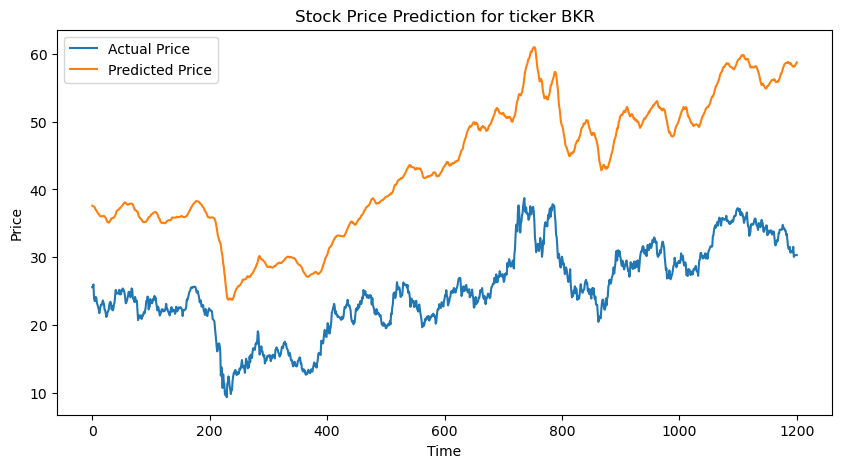

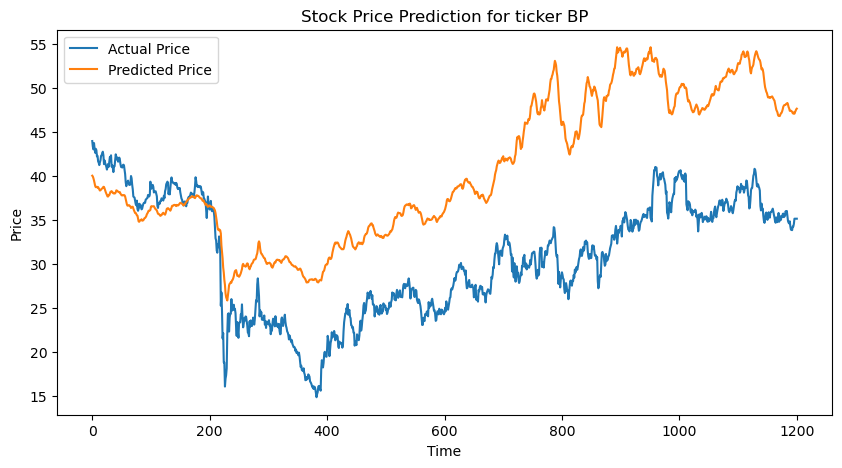

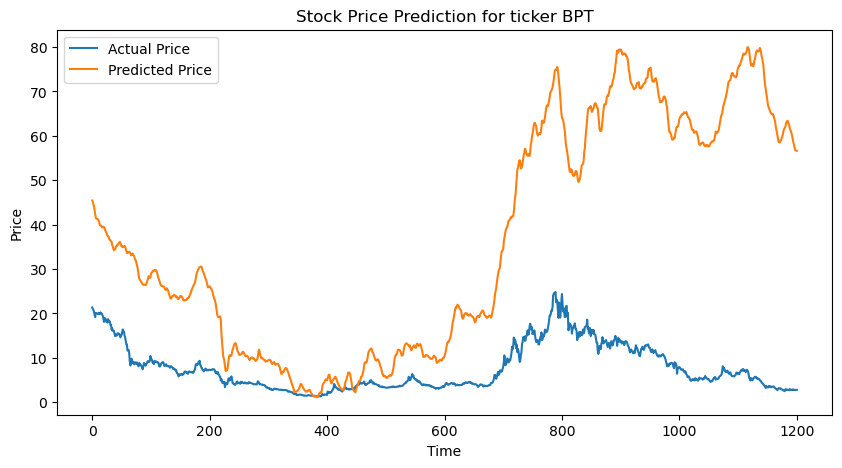

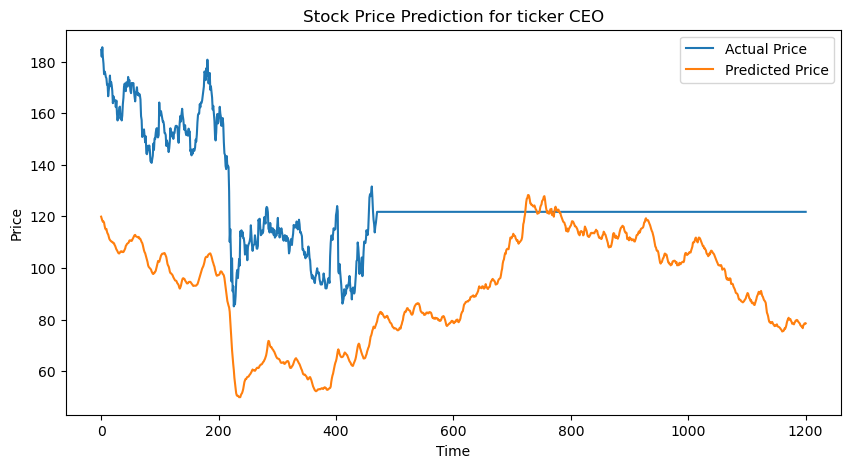

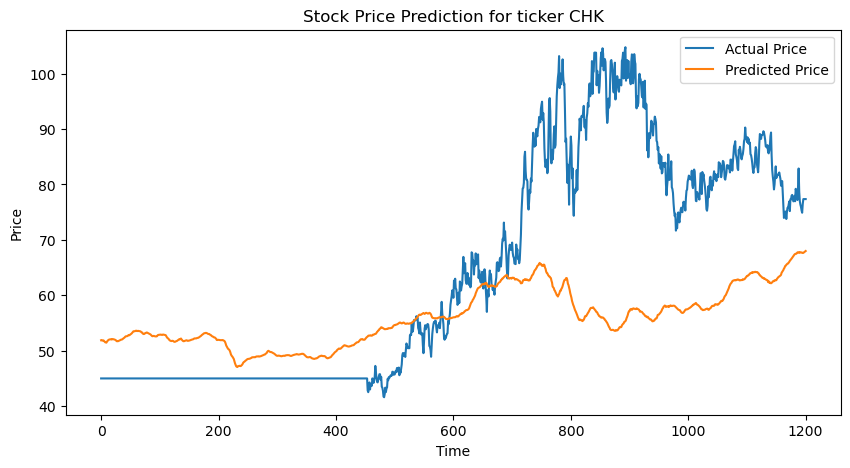

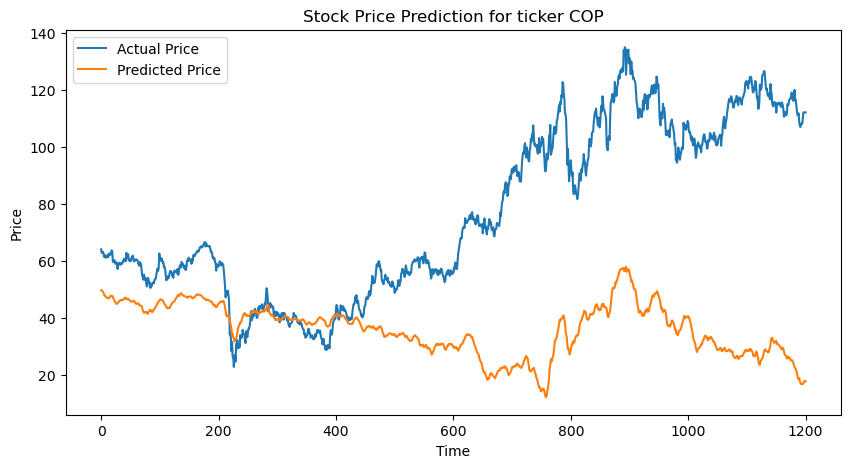

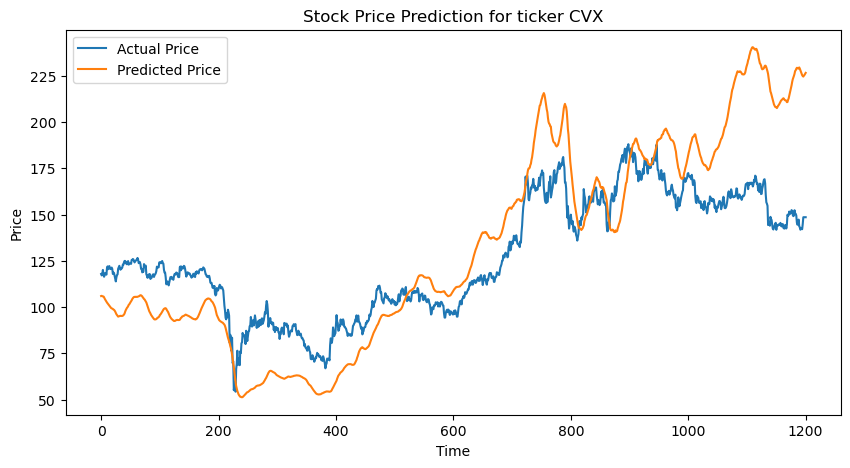

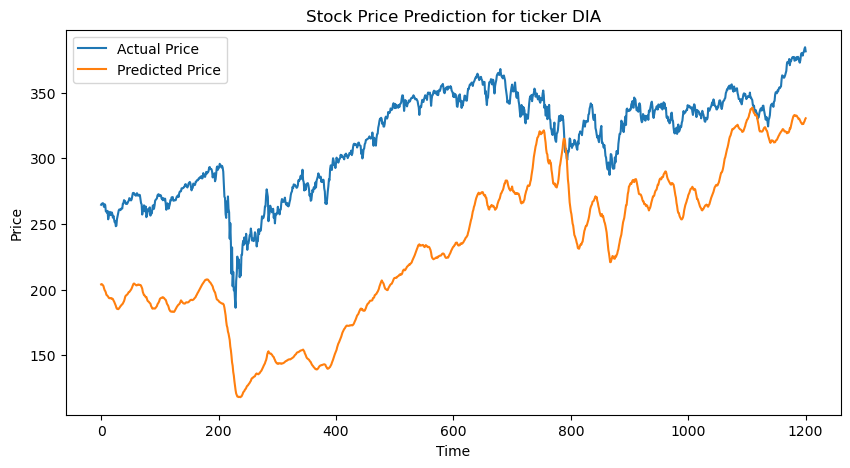

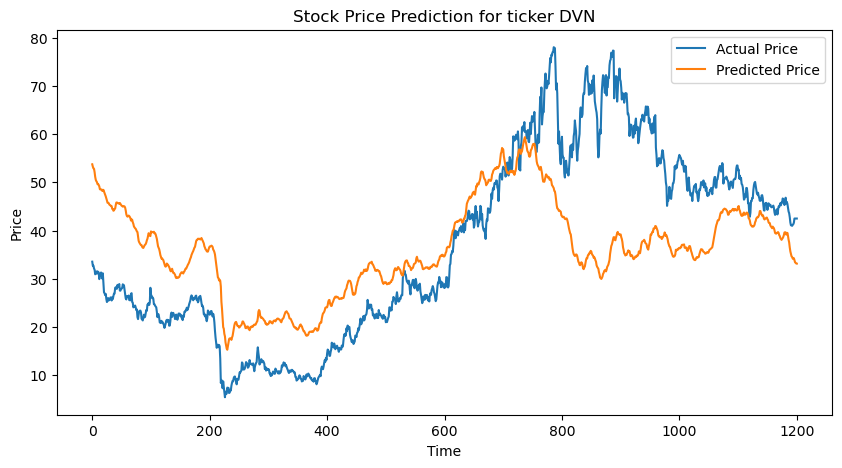

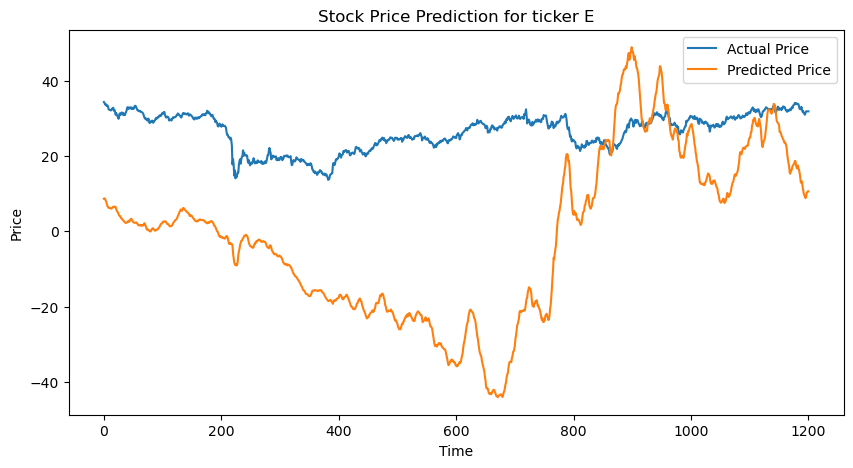

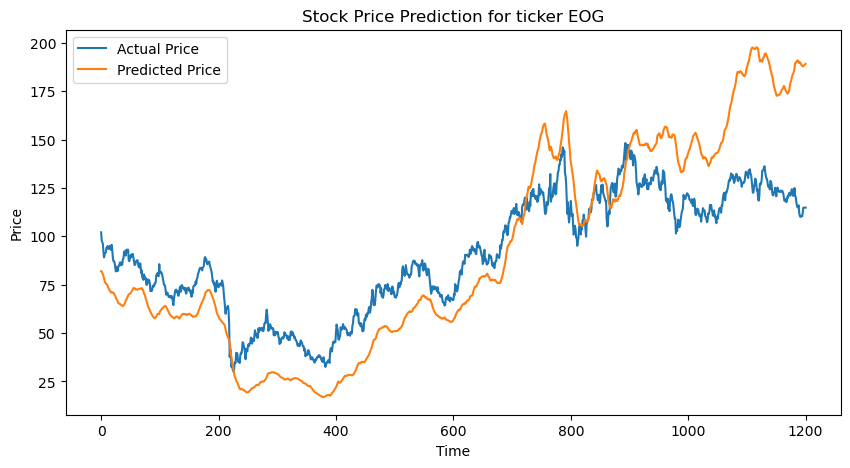

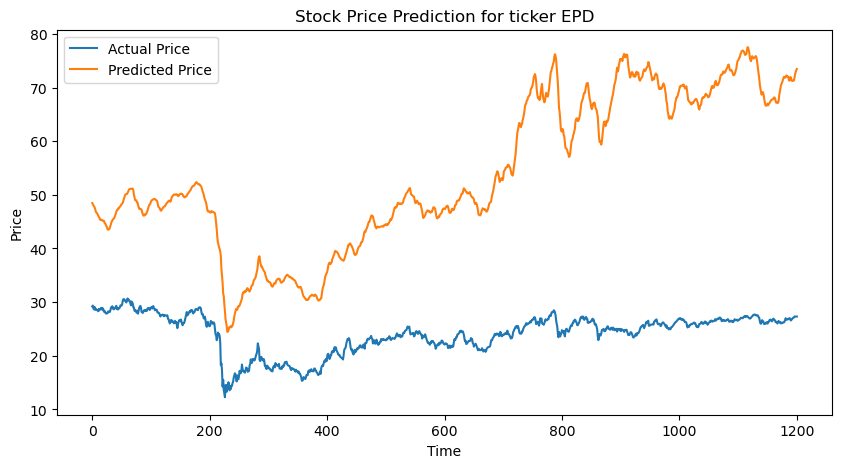

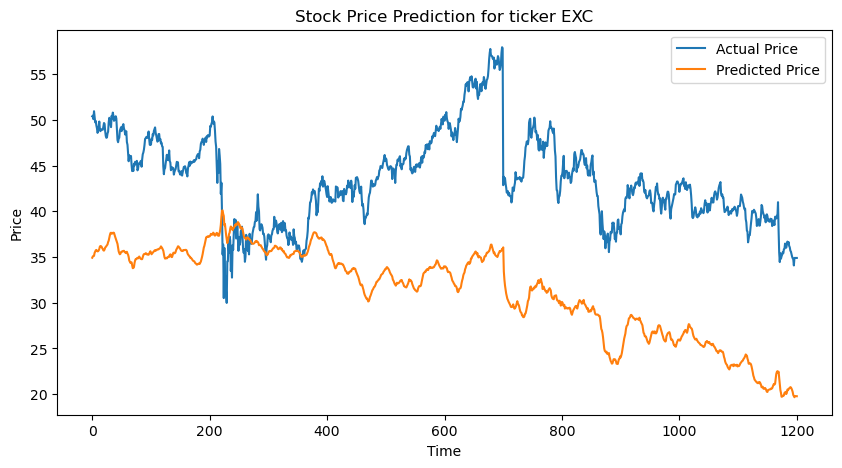

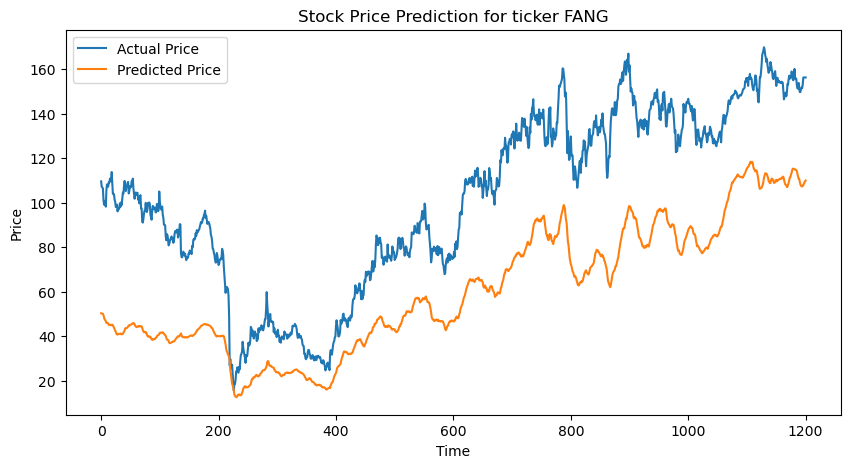

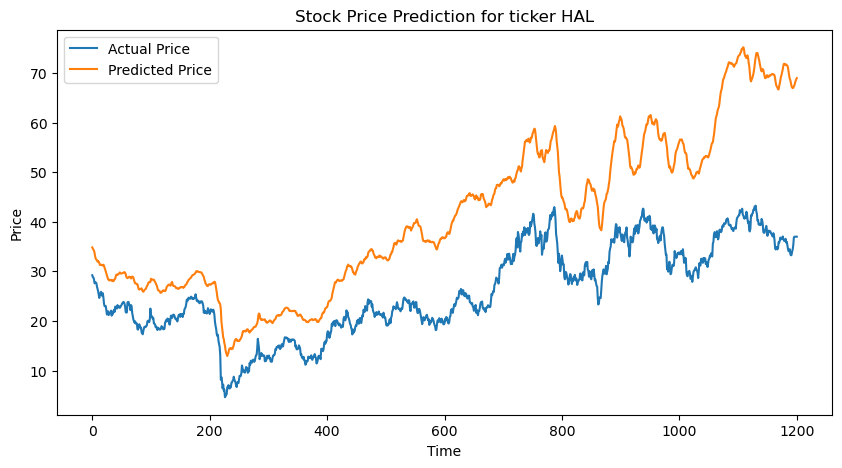

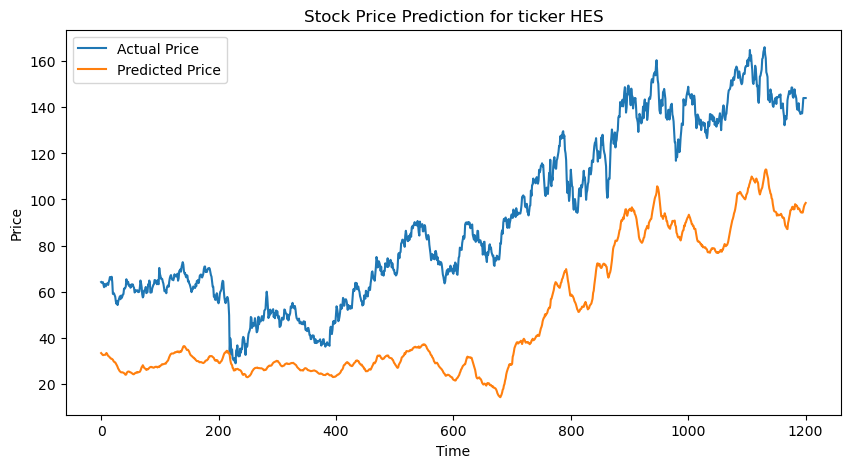

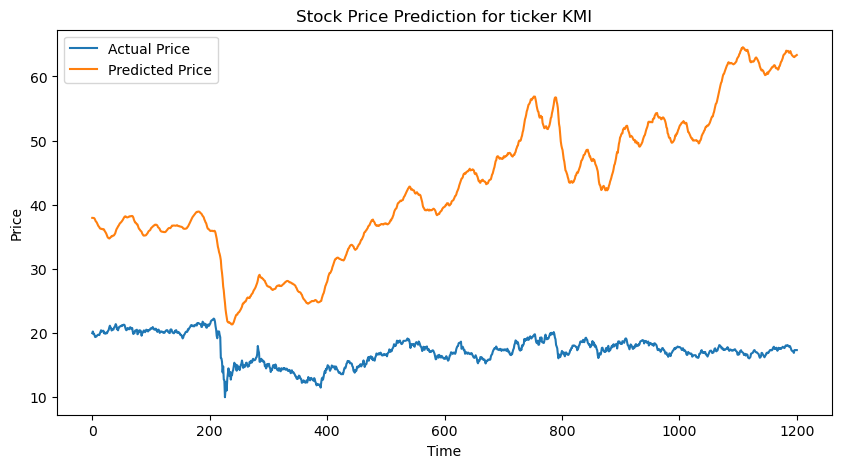

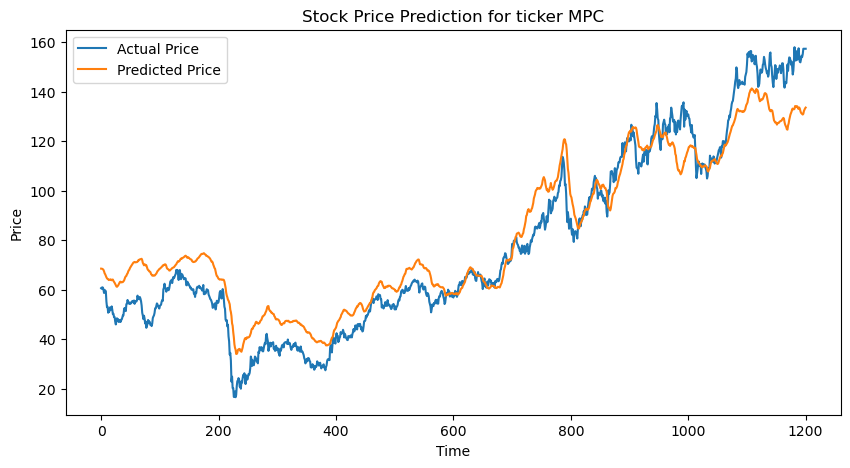

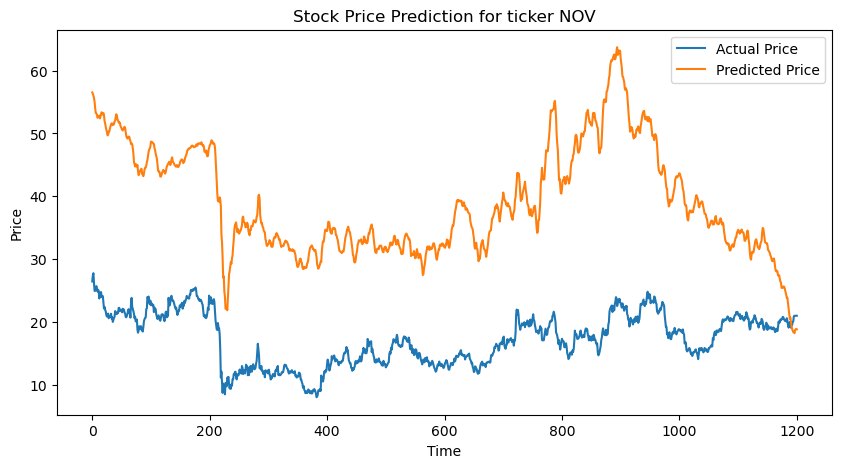

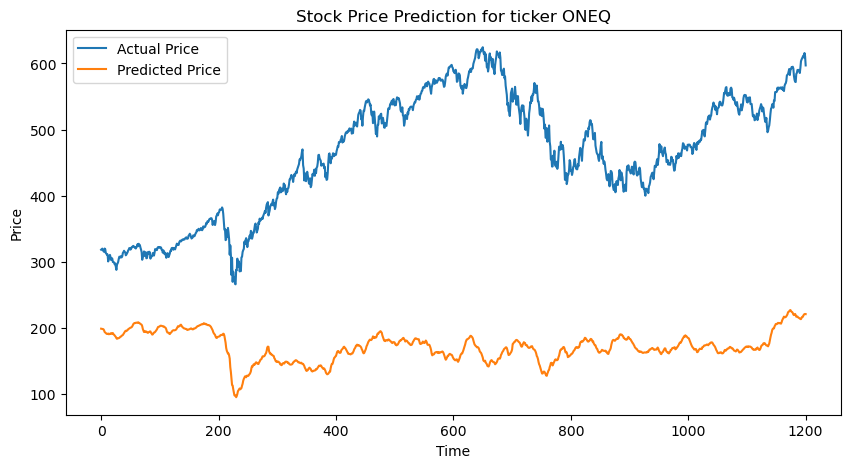

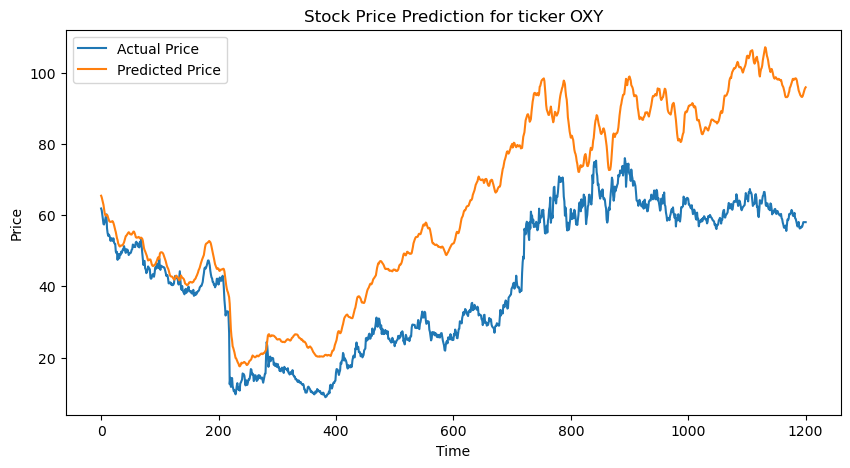

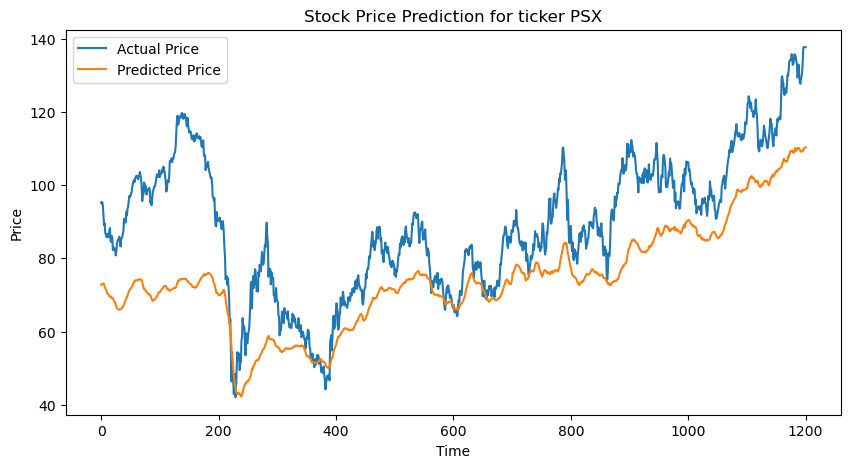

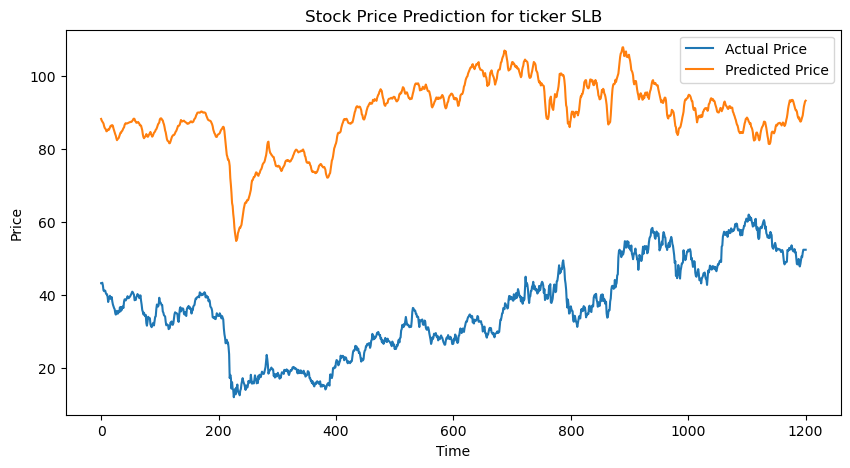

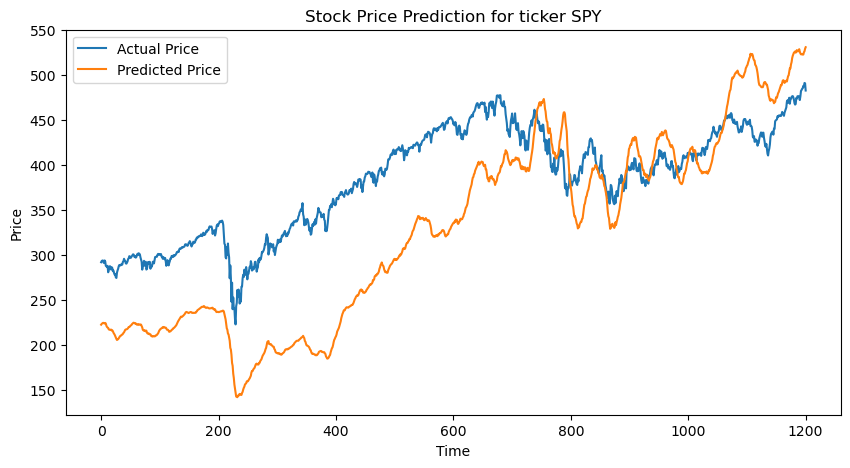

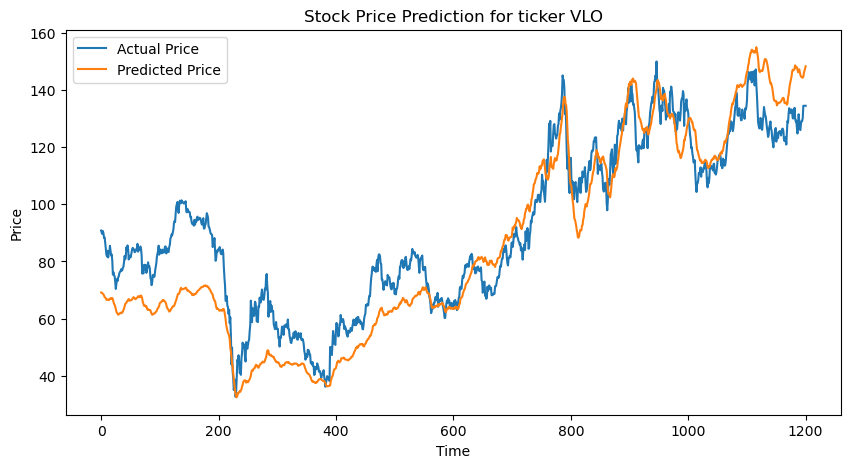

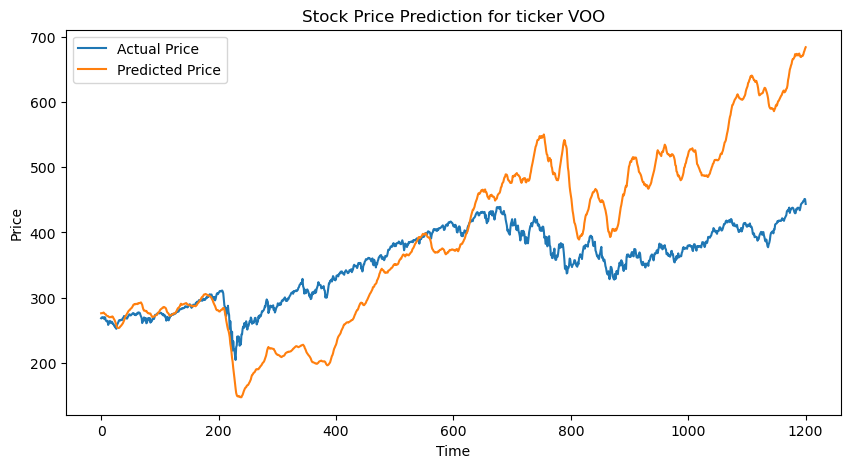

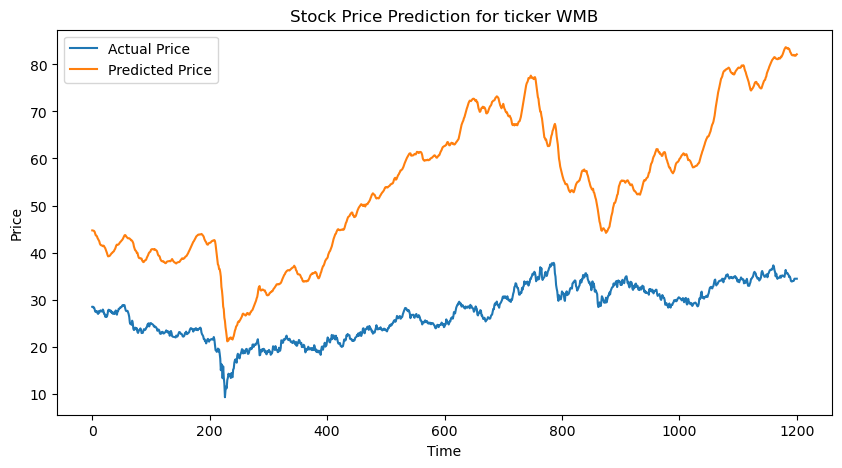

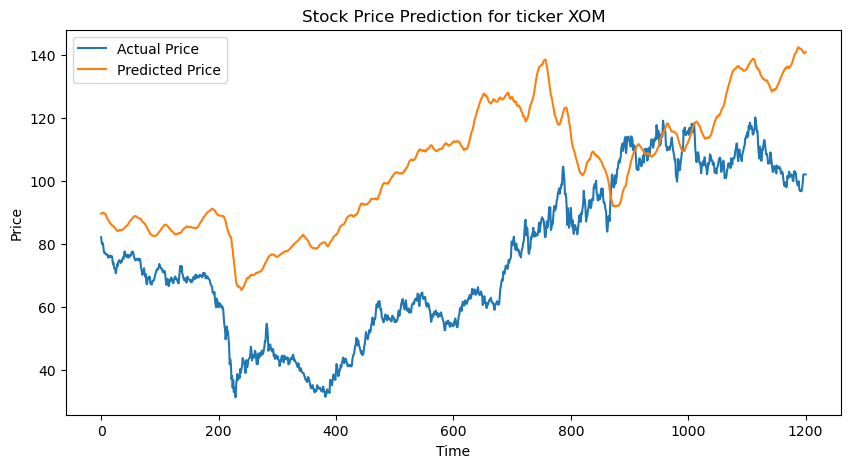

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# fill NaN values if necessary
pivoted_s_e_filled = pivoted_s_e.ffill().bfill()

# scale data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(pivoted_s_e_filled)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length), :]
        y = data[i + seq_length, :]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 100
X, y = create_sequences(close_prices_scaled, seq_length)

# split data
split = int(X.shape[0] * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# build LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(y_train.shape[1])
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# train model
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)

# predict
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)

# plot
for ticker_idx in range(len(pivoted_s_e.columns)):
    plt.figure(figsize=(10, 5))
    plt.plot(scaler.inverse_transform(y_test)[:, ticker_idx], label='Actual Price')
    plt.plot(predicted_prices[:, ticker_idx], label='Predicted Price')
    plt.title(f'Stock Price Prediction for ticker {pivoted_s_e_filled.columns[ticker_idx]}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


Epoch 1/5
120/120 [==============================] - 4s 28ms/step - loss: 0.0412 - val_loss: 0.0523
Epoch 2/5
120/120 [==============================] - 3s 25ms/step - loss: 0.0082 - val_loss: 0.0360
Epoch 3/5
120/120 [==============================] - 3s 25ms/step - loss: 0.0050 - val_loss: 0.0318
Epoch 4/5
120/120 [==============================] - 3s 25ms/step - loss: 0.0037 - val_loss: 0.0294
Epoch 5/5
38/38 [==============================] - 1s 13ms/step


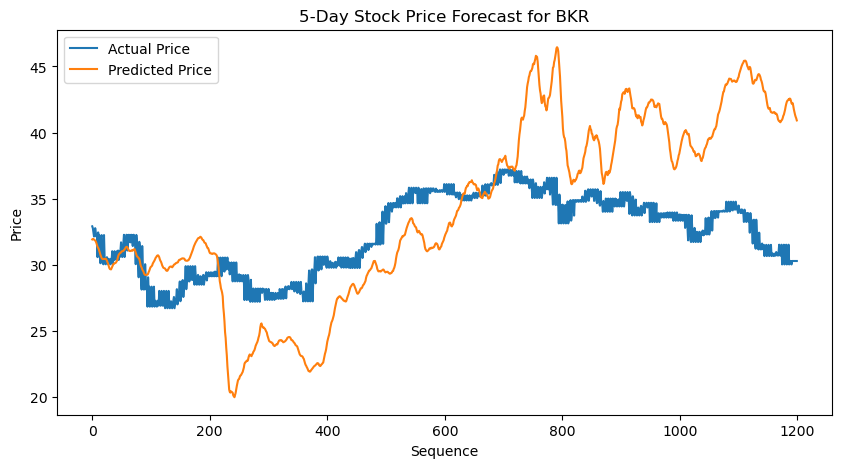

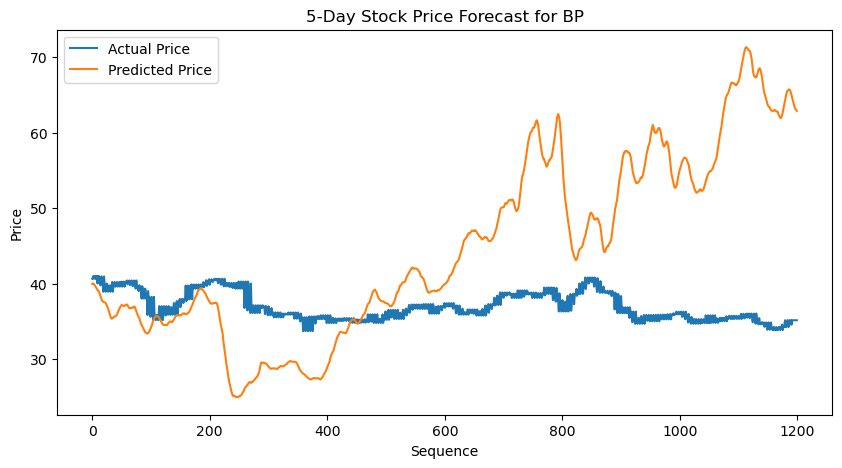

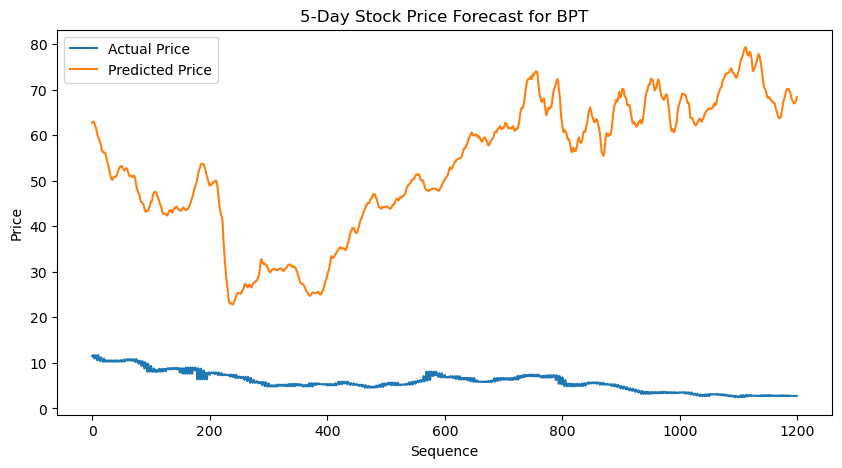

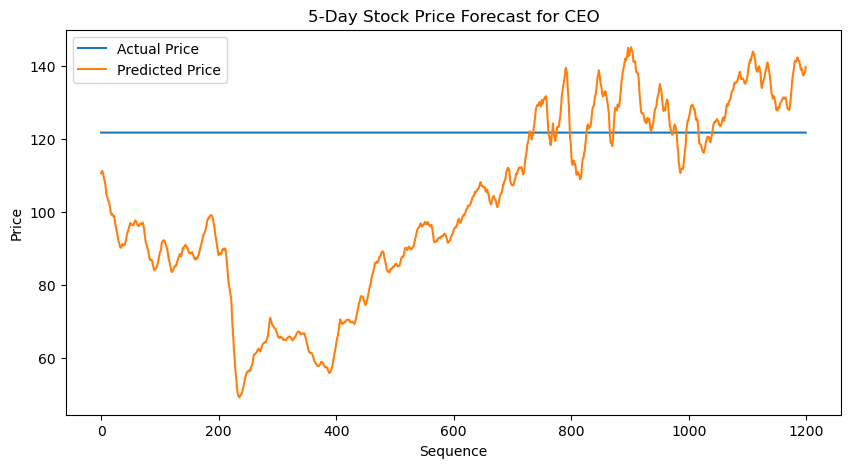

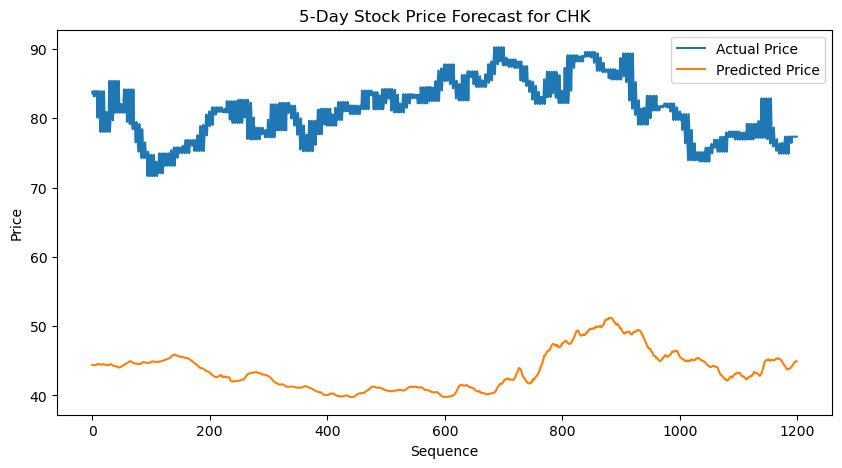

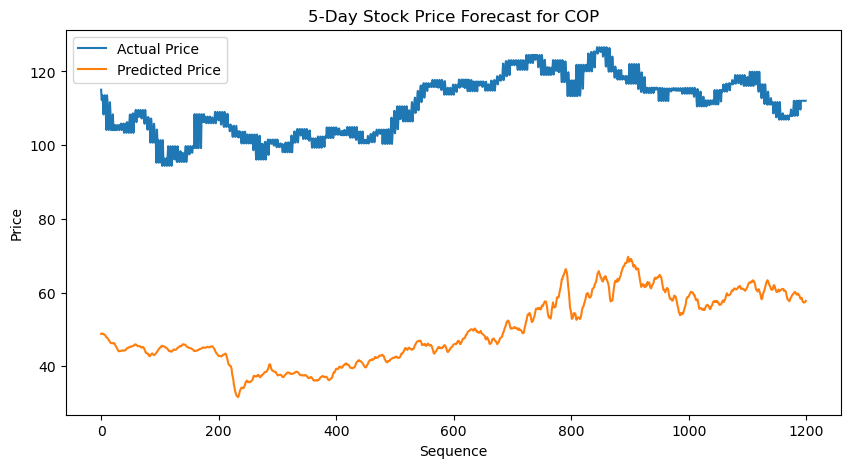

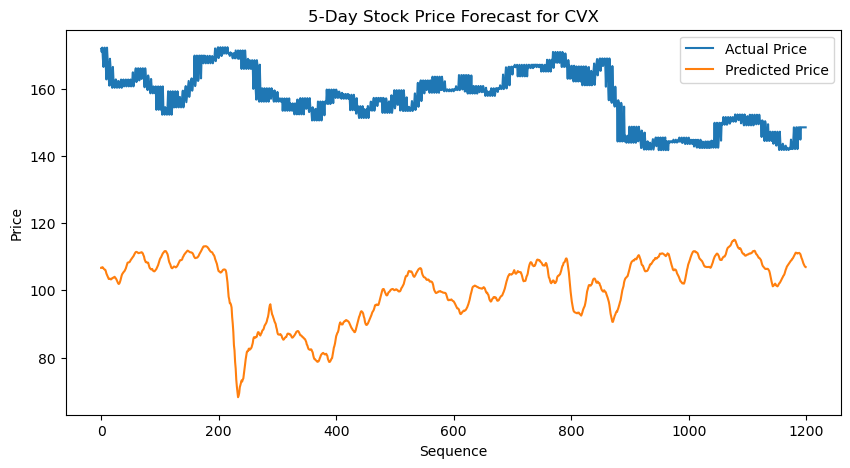

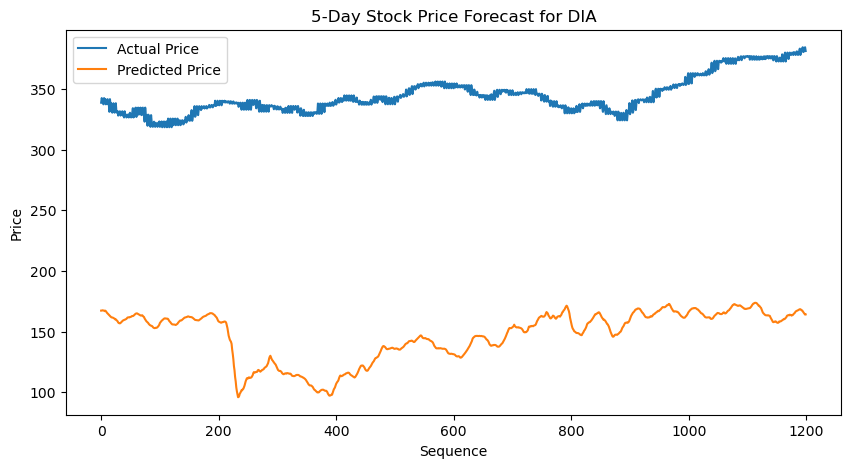

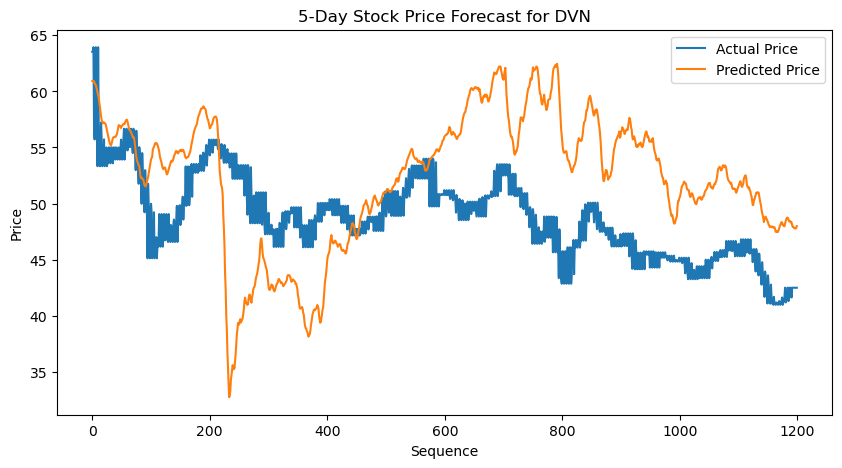

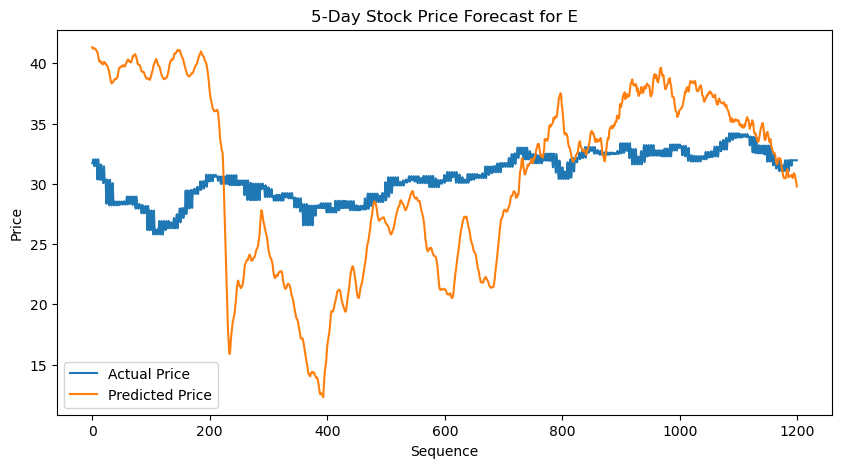

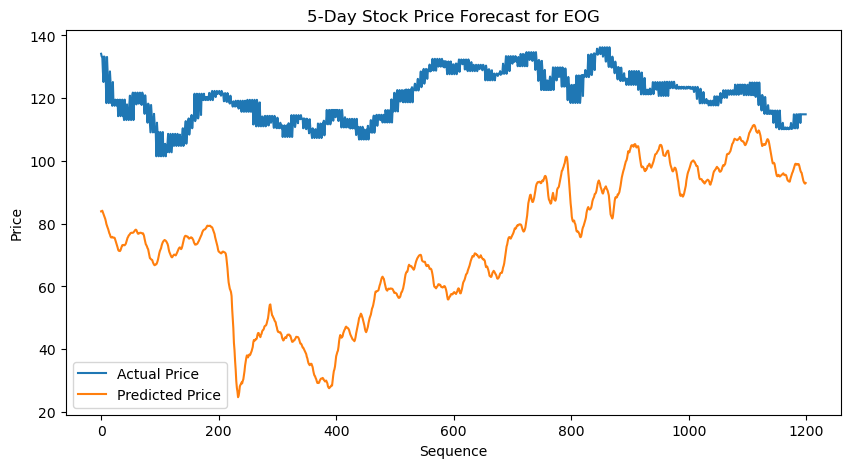

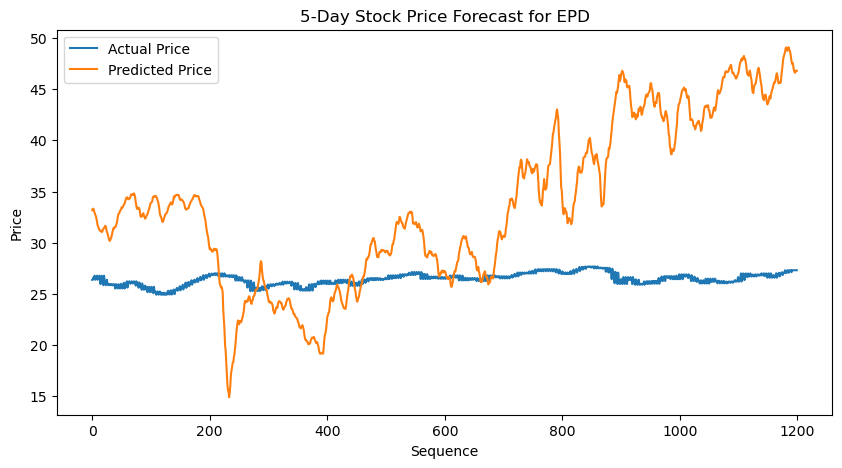

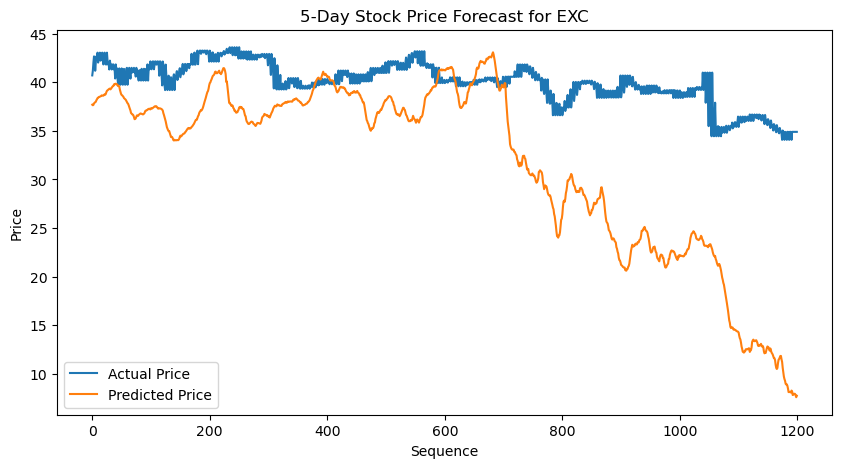

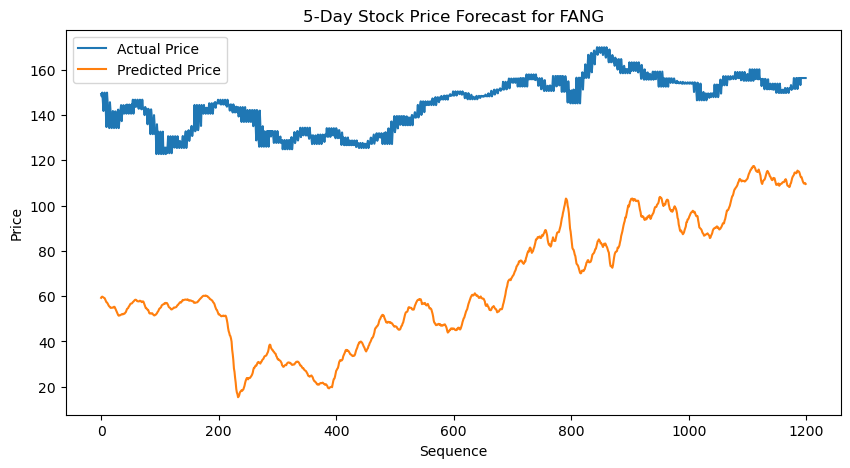

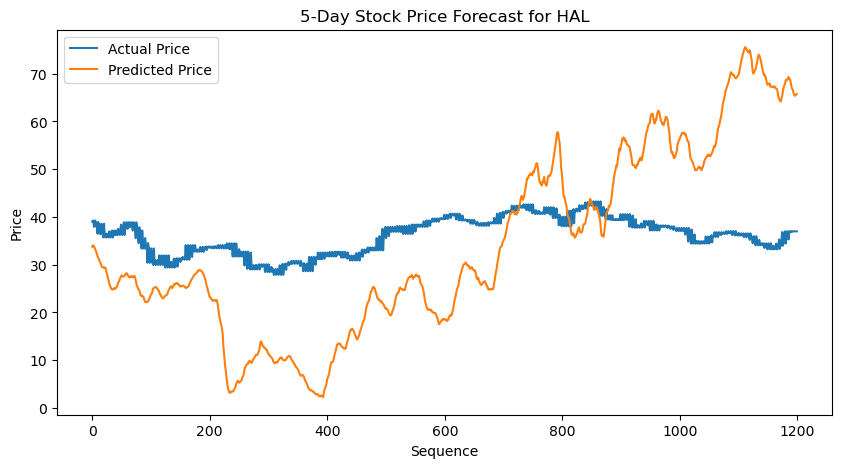

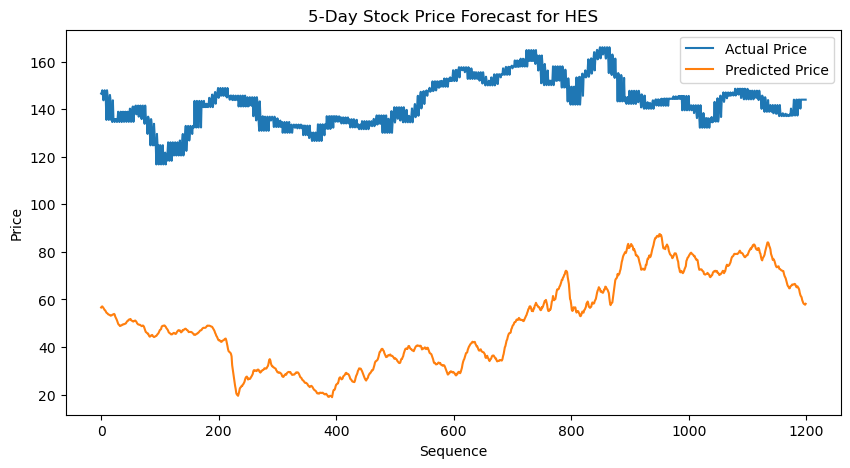

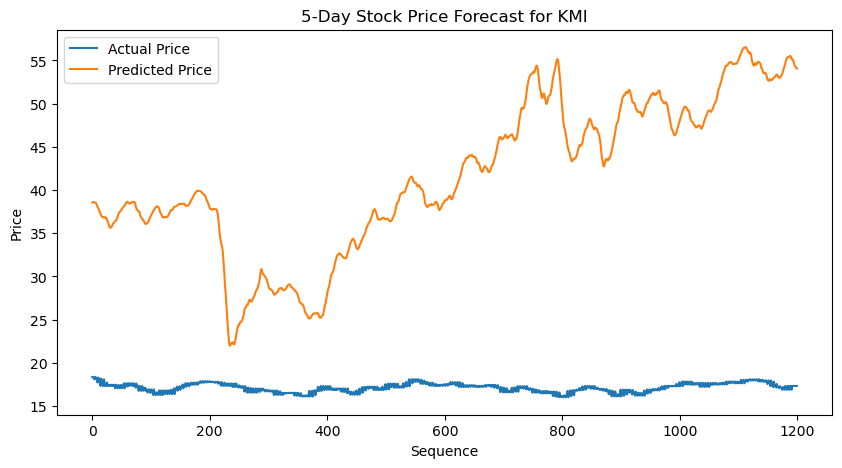

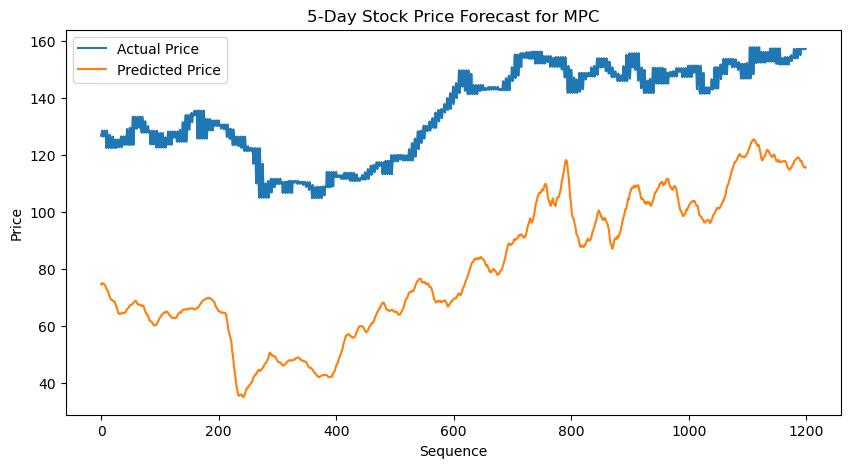

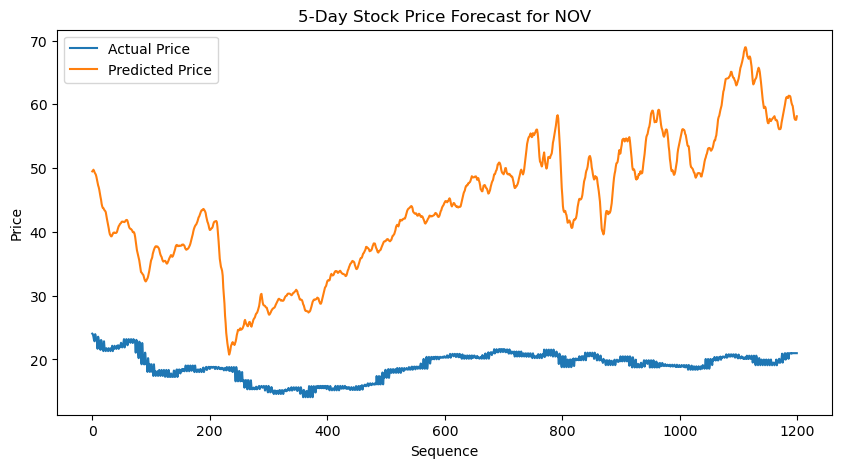

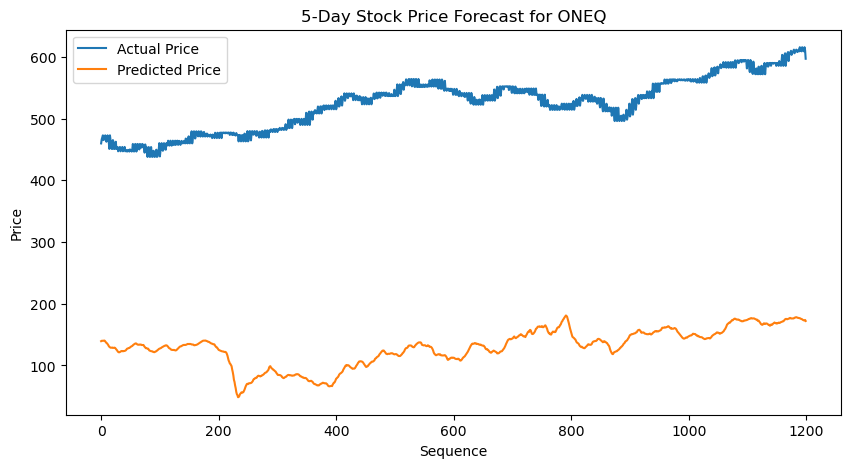

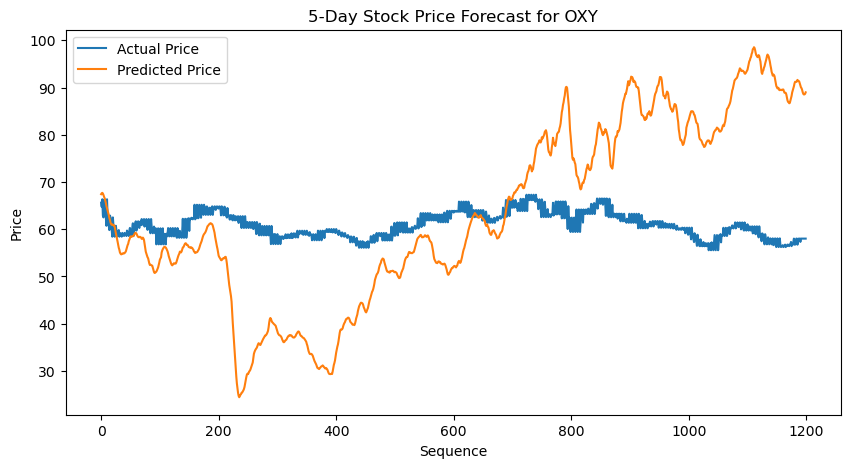

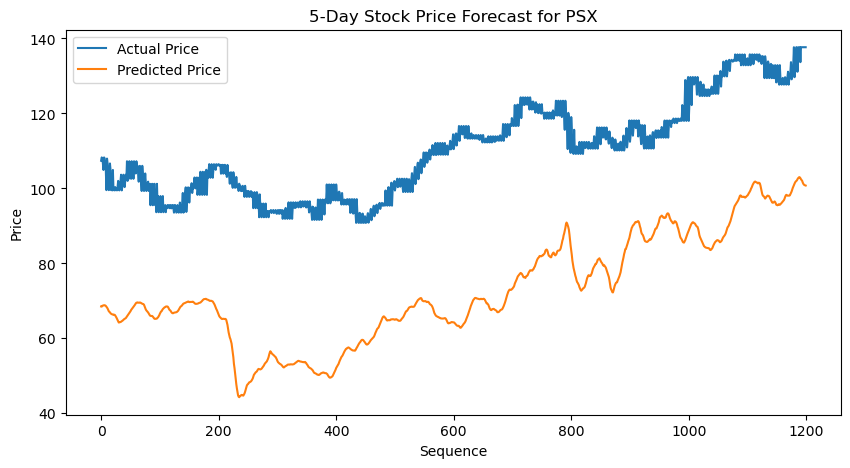

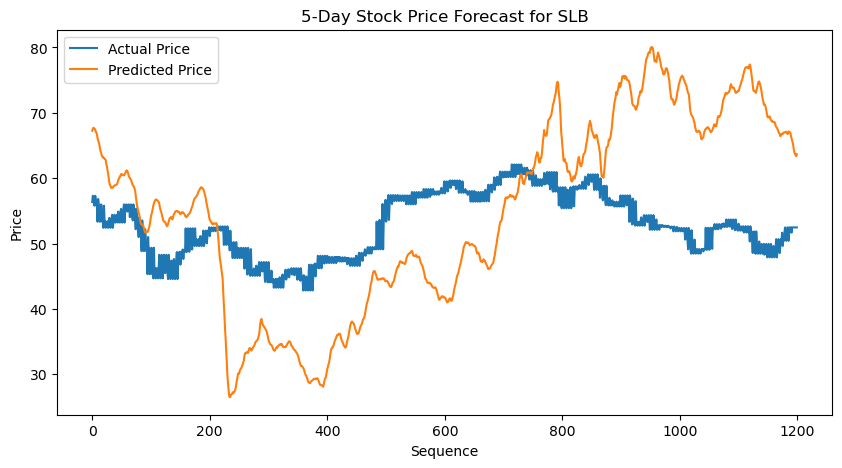

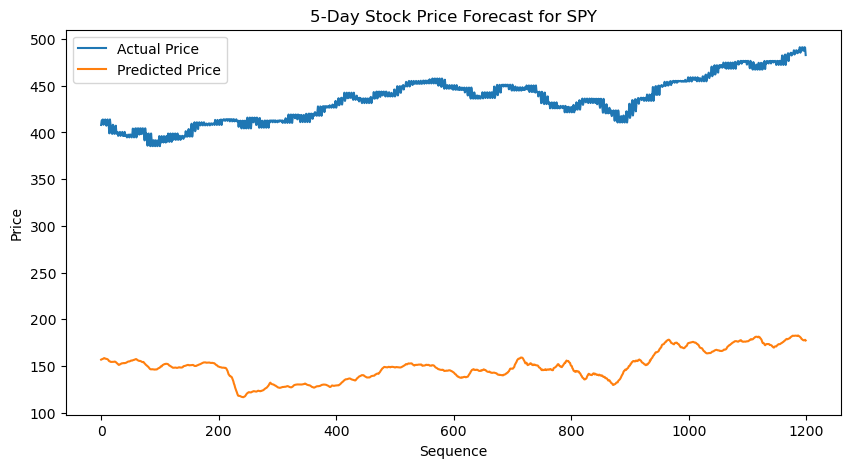

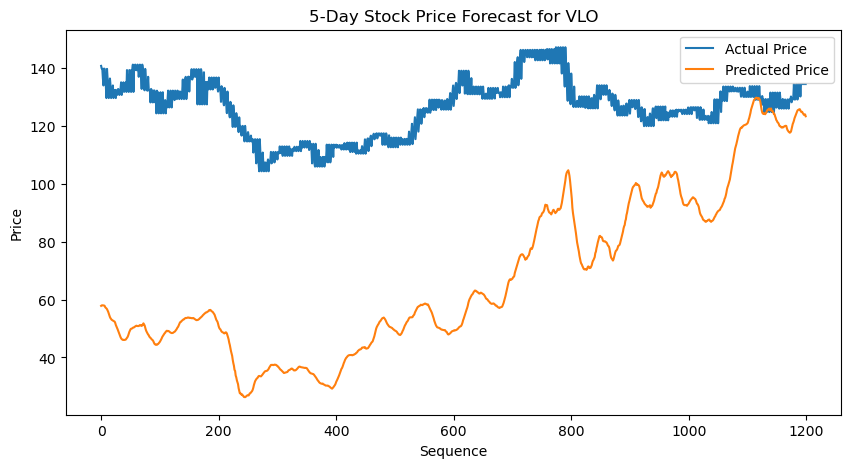

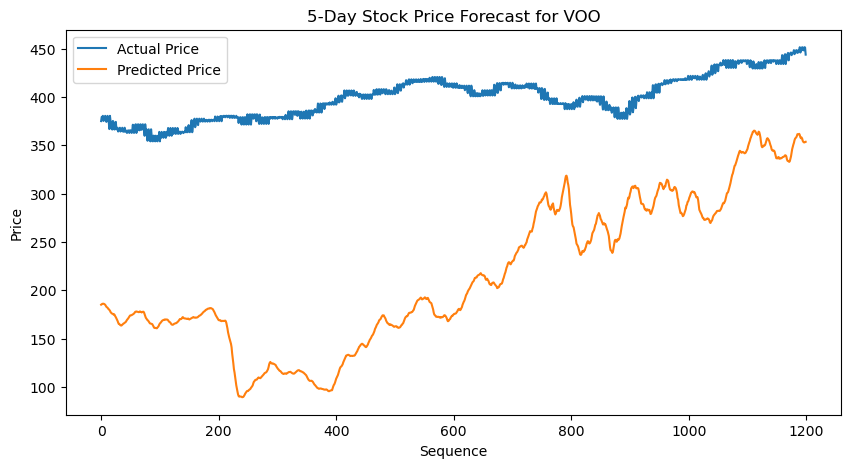

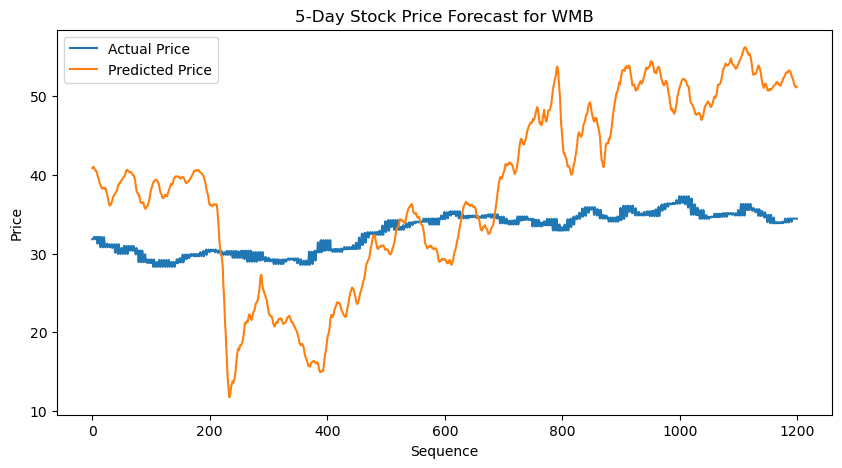

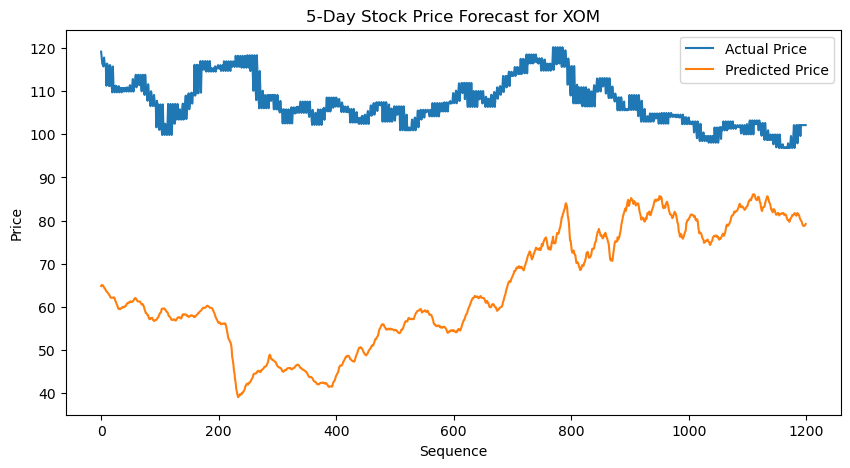

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming pivoted_s_e is already defined
pivoted_s_e_filled = pivoted_s_e.ffill().bfill()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(pivoted_s_e_filled)

def create_sequences(data, seq_length, n_days_future):
    xs, ys = [], []
    for i in range(len(data) - seq_length - n_days_future):
        x = data[i:(i + seq_length), :]
        y = data[(i + seq_length):(i + seq_length + n_days_future), :]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 100
n_days_future = 5  # Number of days you want to predict into the future
X, y = create_sequences(close_prices_scaled, seq_length, n_days_future)

# Split data
split = int(X.shape[0] * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM for multi-step forecasting
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(y_train.shape[1] * y_train.shape[2])  # Adjust for multi-day output
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1), epochs=5, validation_split=0.2, verbose=1)

# Predict
predicted = model.predict(X_test)

# Since the model's output is in a flattened format for multiple days and features,
# we first need to ensure it's in the correct shape for inverse scaling.
# Reshape predicted to [num_samples * n_days_future, num_features]
predicted_2D = predicted.reshape(-1, pivoted_s_e_filled.shape[1])

# Apply inverse transformation
predicted_prices_2D = scaler.inverse_transform(predicted_2D)

# Now, reshape the predictions back to [num_samples, n_days_future, num_features] for plotting
predicted_prices = predicted_prices_2D.reshape(-1, n_days_future, pivoted_s_e_filled.shape[1])

# Plotting adjustments for predicted_prices with corrected reshaping
for ticker_idx in range(len(pivoted_s_e_filled.columns)):
    plt.figure(figsize=(10, 5))
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, pivoted_s_e_filled.shape[1]))[:, ticker_idx]  # Reshape y_test and select ticker
    plt.plot(actual_prices[-predicted_prices.shape[0]:], label='Actual Price')  # Match the lengths of actual and predicted
    plt.plot(predicted_prices[:, 0, ticker_idx], label='Predicted Price')  # First day prediction for simplicity
    plt.title(f'{n_days_future}-Day Stock Price Forecast for {pivoted_s_e_filled.columns[ticker_idx]}')
    plt.xlabel('Sequence')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow.keras.optimizers import Adam
# import matplotlib.pyplot as plt

# # load data
# # data = pd.read_csv('your_stock_data.csv')
# close_prices = pivoted_s_e['BKR'].values


In [ ]:

# # scale data
# scaler = MinMaxScaler(feature_range=(0, 1))
# close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

# # create sequences
# def create_sequences(data, seq_length):
#     xs, ys = [], []
#     for i in range(len(data) - seq_length - 1):
#         x = data[i:(i + seq_length)]
#         y = data[i + seq_length]
#         # check if `x` or `y` contains NaN and skip if true
#         if not np.isnan(x).any() and not np.isnan(y):
#             xs.append(x)
#             ys.append(y)
#     return np.array(xs), np.array(ys)

# seq_length = 100
# X, y = create_sequences(close_prices_scaled, seq_length)
# X = X.reshape((X.shape[0], X.shape[1], 1))

# # build LSTM
# model = Sequential([
#     LSTM(50, activation='relu', input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# # train model
# split = int(len(X) * 0.8)
# X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
# history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)

# # check for NaNs in data
# assert not np.isnan(X_train).any(), "NaNs in X_train"
# assert not np.isnan(y_train).any(), "NaNs in y_train"

# # plot training & validation loss values
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc="upper left")
# plt.show()

# # predict (optional)
# predicted = model.predict(X_test)
# # predicted_prices = scaler.inverse_transform(predicted)

# # plotting the real vs predicted prices
# plt.figure(figsize=(10, 5))
# plt.plot(y_test, color='blue', label='Actual Stock Price')
# plt.plot(predicted[:, 0], color='red', label='Predicted Stock Price')
# plt.title('Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.show()
